1 INTRODUCTION

In this Jupyter Notebook file, our goal is to explain how to develop a full model to predict house prices from some features using PySpark, referring to the challenge "House Prices - Advanced Regression Techniques" on Kaggle.

Before choosing the model and building the training pipeline, we will invest time in a careful data preprocessing, in order to deeply analyze our features.

2 CONFIGURATION OF THE ENVIRONMENT AND DATA IMPORT

Let's import all the useful libraries we will need to in this work.

In addiction to pyspark libraries, we will use matplotlib and seaborn to better visualize data.

In [88]:
import findspark
location = findspark.find()
findspark.init(location)

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType

from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import os

Now, let's create the Spark session; next load train and test data as dataframes.

In [89]:
spark = SparkSession.builder.getOrCreate()

trainDF = spark.read.csv('./DatiProgetto/train.csv', header = 'True', inferSchema = 'True')
testDF = spark.read.csv('./DatiProgetto/test.csv', header = 'True', inferSchema = 'True')

print("Training set: \n")
trainDF.printSchema()

print("Test set: \n")
testDF.printSchema()

Training set: 

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nulla

2 'SALEPRICE' ANALYSIS

As we already said, our goal is to predict house prices from a series of features. So, first of all, let's visualize some statistics about our feature of interest "SalePrice" in training data.

In [3]:
trainDF.select(trainDF.SalePrice).describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+



We can observe that the range of SalePrice is between 34900 and 755000, but the mean is about 18000, so it's not exactly in the middle of the range: this means we expect to have a distribution where values are concentrated in the range between min and mean rather than mean and max.

Let's visualize the probability distribution of SalePrice.

Text(0, 0.5, 'Density')

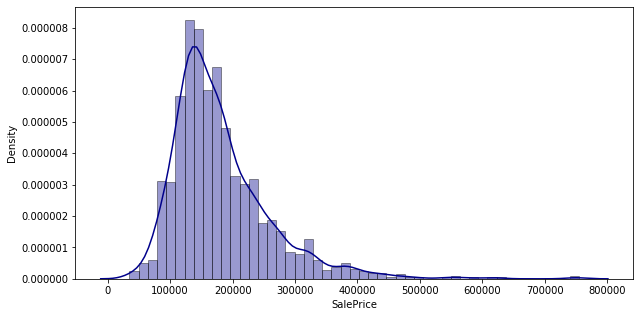

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
dist = sns.distplot(trainDF.select('SalePrice').collect(), hist = True, kde = True, color = 'darkblue', hist_kws={'edgecolor':'black'})
dist.set_xlabel('SalePrice')
dist.set_ylabel('Density')

As we expected, it isn't a simmetric distribution, as we have a positive skewness. This fact could suggest the presence of some outliers... let's keep it in mind for later.

3 DATA PREPROCESSING

Data preprocessing is a fundamental step, as bad data negatively affect the performance of the model, making it inaccurate.

Our goals are:
1. to verify if there are any missing values, and eventually manage them;
2. to verify if there are any outliers, and eventually manage them;
3. to select only relevant features.


3.1 MISSING VALUES MANAGEMENT

Let's verify if missing values are present in training and test data.

In [5]:
def count_null_values(df) :
    cols_counts = []
    for i in df.columns :
        null_count = df.where(col(i).isNull()).count()
        if (null_count > 0 ) :
            col_count = (i, null_count)
            cols_counts.append(col_count)
    return cols_counts


null_counts_train = count_null_values(trainDF)
if null_counts_train :
    null_counts_trainDF = spark.createDataFrame(data=null_counts_train, schema = ["Col", "Null_Counts"])
    null_counts_trainDF.orderBy('Null_Counts').show()
else :
    print("No missing values in train set \n")
    

null_counts_test = count_null_values(testDF)
if null_counts_test :
    null_counts_testDF = spark.createDataFrame(data = null_counts_test, schema = ["Col", "Null_Counts"])
    null_counts_testDF.orderBy('Null_Counts').show()
else :
    print("No missing values in test set \n")

No missing values in train set 

No missing values in test set 



In this first analysis, it seems that there aren't any missing values, but we have to pay attenction: if we observe our data, we can notice that there are several values marked as 'NA'. Consulting the description of our features on Kaggle, for some categorical features the 'NA' values are expected, as it doesn't mean the value is 'Not Available' for that feature, but that the feature itself is not present in the house (for example: a house without a garage). In this cases the 'NA' values are relevant for our task (a house with a garage could cost more than a house without a garage). 

But this situation isn't valid for all the features!

Let's analyze 'NA' values:

In [6]:
def count_na_values(df) :
    cols_counts = []
    for i in df.columns :
        na_count = df.where(col(i) == 'NA').count()
        if na_count > 0 :
            col_count = (i, na_count)
            cols_counts.append(col_count)
    return cols_counts


na_counts_train = count_na_values(trainDF)
if na_counts_train :
    na_counts_trainDF = spark.createDataFrame(data=na_counts_train, schema = ["Col", "NA_counts"])
    na_counts_trainDF.sort('NA_Counts', ascending=False).show()
else :
    print("No NA values in train set \n")
    

na_counts_test = count_na_values(testDF)
if na_counts_test :
    na_counts_testDF = spark.createDataFrame(data=na_counts_test, schema = ["Col", "NA_Counts"])
    na_counts_testDF.orderBy('NA_Counts', ascending=False).show()
else :
    print("No NA values in test set \n")

+------------+---------+
|         Col|NA_counts|
+------------+---------+
|      PoolQC|     1453|
| MiscFeature|     1406|
|       Alley|     1369|
|       Fence|     1179|
| FireplaceQu|      690|
| LotFrontage|      259|
|GarageFinish|       81|
|  GarageCond|       81|
| GarageYrBlt|       81|
|  GarageQual|       81|
|  GarageType|       81|
|BsmtExposure|       38|
|BsmtFinType2|       38|
|    BsmtCond|       37|
|BsmtFinType1|       37|
|    BsmtQual|       37|
|  MasVnrArea|        8|
|  MasVnrType|        8|
|  Electrical|        1|
+------------+---------+

+------------+---------+
|         Col|NA_Counts|
+------------+---------+
|      PoolQC|     1456|
| MiscFeature|     1408|
|       Alley|     1352|
|       Fence|     1169|
| FireplaceQu|      730|
| LotFrontage|      227|
|  GarageQual|       78|
|GarageFinish|       78|
| GarageYrBlt|       78|
|  GarageCond|       78|
|  GarageType|       76|
|    BsmtCond|       45|
|    BsmtQual|       44|
|BsmtExposure|       44|

Actually, as we expected, most of the features with 'NA' values are categorical features that allow 'NA' as a possible category. In these cases we will keep 'NA' values as categorical values.

Nevertheless, there are some cases in which we have 'NA' values even if they are not allowed: some of these features are categorical, while others are numerical. So we have to analyze those features in order to manage missing data. 

In particular, we have to analyze:

Numerical features with 'NA' values:
1. LotFrontage
2. GarageYrBlt
3. MasVnrArea
4. BsmtFinSF1
5. BsmtFinSF2
6. GarageCars
7. TotalBsmtSF
8. BsmtUnfSF
9. GarageArea
10. BsmtFullBath
11. BsmtHalfBath

Categorical features with 'NA' values:
1. MasVnrType
2. Electrical
3. Exterior2nd
4. Sale type
5. Exterior1st
6. KitchenQual
7. Functional
8. Utilities
9. MSZoning

First of all, due to the presence of 'NA' values, all the values of the numerical features listed above are considered string. So we have to do an explicit cast.

In [90]:
quantitative_features = ("LotFrontage", "GarageYrBlt", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", \
    "GarageCars", "TotalBsmtSF", "BsmtUnfSF", "GarageArea", "BsmtFullBath", "BsmtHalfBath")

for i in quantitative_features :
    trainDF = trainDF.withColumn(i, col(i).cast("Integer"))
    testDF = testDF.withColumn(i, col(i).cast("Integer"))


trainDF.printSchema()
testDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

LotFrontage

LotFrontage represents linear feet of street connected to property. We can suppose every house has a street connected to it, so it doesn't make any sense to set all the NA values to 0 in this case. So our decision is to set NA values to the median considering all the values in LotFrontage, in order to ensure consistency and indipendence from possibile outliers.
As median is a statistic measure, it results more accurate if we calculate it on the union of train and test set.

In [91]:
unionDF = trainDF["Id", "LotFrontage"].unionByName(testDF["Id", "LotFrontage"])

median_list = unionDF.select(percentile_approx("LotFrontage", 0.5).alias("Median")).collect()
print(median_list)
median = median_list[0][0]

trainDF = trainDF.withColumn('LotFrontage', when((col('LotFrontage').isNull()), median).otherwise(trainDF['LotFrontage']))
testDF = testDF.withColumn('LotFrontage', when((col('LotFrontage').isNull()), median).otherwise(testDF['LotFrontage']))

[Row(Median=68)]


GarageYrBlt, GarageCars, GarageArea

GarageYrBlt represents the year in which the garage was built. Tipically, it is null only if the house has no garage.
Let's visualize the number of houses without a garage in train and test set:

In [92]:
garageTrainDF = trainDF.select("GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", \
    "GarageArea", "GarageQual", "GarageCond").where((trainDF.GarageType == 'NA') & \
        (trainDF.GarageQual == 'NA') & (trainDF.GarageCond == 'NA') & (trainDF.GarageFinish == 'NA'))

rows = garageTrainDF.count()
print(f"Number of rows for houses whithout garage in TrainSet : {rows}")

garageTestDF = testDF.select("GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", \
    "GarageArea", "GarageQual", "GarageCond").where((testDF.GarageType == 'NA') & \
        (testDF.GarageQual == 'NA') & (testDF.GarageCond == 'NA') & (testDF.GarageFinish == 'NA'))

rows = garageTestDF.count()
print(f"Number of rows for houses whithout garage in TestSet : {rows}")

Number of rows for houses whithout garage in TrainSet : 81
Number of rows for houses whithout garage in TestSet : 76


In train data we have 81 houses without a garage, and it matches with the number of times in which GarageYrBuilt has null values.

In test data we have 76 houses without a garage, but we have 78 cases in which GarageYrBuilt has a null value!

Let's visualize these two records:

In [93]:
testDF.select("Id", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", \
    "GarageArea", "GarageQual", "GarageCond").where((testDF.GarageType != 'NA') & (testDF.GarageYrBlt.isNull())).show()

+----+----------+-----------+------------+----------+----------+----------+----------+
|  Id|GarageType|GarageYrBlt|GarageFinish|GarageCars|GarageArea|GarageQual|GarageCond|
+----+----------+-----------+------------+----------+----------+----------+----------+
|2127|    Detchd|       null|          NA|         1|       360|        NA|        NA|
|2577|    Detchd|       null|          NA|      null|      null|        NA|        NA|
+----+----------+-----------+------------+----------+----------+----------+----------+



These records are anomalous, because they have a specific GarageType that is not NA, so the garage is present in the house, but GarageFinish, GarageQual e GarageCond are NA, and the description tells us these features should be NA only when the house has no garage!

Our solution is the following: tipically, the year in which the garage was built (GarageYrBlt) is the same year in which the entire house was built (YearBuilt), so we can make this assumption and replace the NA values with respective values in YearBuilt.

GarageQual and GarageCond are ordinal categorical features that represent the quality and the condition of the garage, so we can replace NA values with the intermediate value ('TA'), as it's defined "typical" in the description.

To obtain the typical value of GarageFinish, that is the interior finish of the garage, we can just consider the most frequent value, so the mode considering all the non-NA values.

For GarageCars and GarageArea, which represent respectively the max number of cars in the garage and the area of the garage, we can replace NA values with the median, as it represents the typical garage dimension.

In [94]:
testDF = testDF.withColumn('GarageYrBlt', when(((col('Id') == 2127) | (col('Id') ==2577)), col('YearBuilt')).otherwise(testDF['GarageYrBlt']))

testDF = testDF.withColumn('GarageQual', when(((col('Id') == 2127) | (col('Id') ==2577)), 'TA').otherwise(testDF['GarageQual']))

testDF = testDF.withColumn('GarageCond', when(((col('Id') == 2127) | (col('Id') ==2577)), 'TA').otherwise(testDF['GarageCond']))

unionDF = trainDF['Id', 'GarageCars', 'GarageArea', 'GarageFinish', 'GarageType'].unionByName(testDF['Id', 'GarageCars', 'GarageArea', 'GarageFinish', 'GarageType'])

counts_list = unionDF.select('GarageFinish', 'GarageType').where(col('GarageType') != 'NA').groupBy('GarageFinish').count().orderBy('count', ascending=False).collect()
garagefinish_mode = counts_list[0][0]
print(f"Mode for GarageFinish: {garagefinish_mode}")
testDF = testDF.withColumn('GarageFinish', when(((col('Id') == 2127) | (col('Id') ==2577)), garagefinish_mode).otherwise(testDF['GarageFinish']))

median_list1 = unionDF.select(percentile_approx('GarageCars', 0.5).alias('Median')).collect()
garagecars_median = median_list1[0][0]
print(f"Moedian for GarageCars: {garagecars_median}")
testDF = testDF.withColumn('GarageCars', when((col('Id') == 2577), garagecars_median).otherwise(testDF['GarageCars']))

median_list2 = unionDF.select(percentile_approx('GarageArea', 0.5).alias('Median')).collect()
garagearea_median = median_list2[0][0]
print(f"Moedian for GarageArea: {garagearea_median}")
testDF = testDF.withColumn('GarageArea', when((col('Id') == 2577), garagearea_median).otherwise(testDF['GarageArea']))

testDF.select("Id", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", \
    "GarageArea", "GarageQual", "GarageCond").where((col('Id') == 2127) | (col('Id') ==2577)).show()

Mode for GarageFinish: Unf
Moedian for GarageCars: 2
Moedian for GarageArea: 480
+----+----------+-----------+------------+----------+----------+----------+----------+
|  Id|GarageType|GarageYrBlt|GarageFinish|GarageCars|GarageArea|GarageQual|GarageCond|
+----+----------+-----------+------------+----------+----------+----------+----------+
|2127|    Detchd|       1910|         Unf|         1|       360|        TA|        TA|
|2577|    Detchd|       1923|         Unf|         2|       480|        TA|        TA|
+----+----------+-----------+------------+----------+----------+----------+----------+



Now, all the records in which GarageYrBlt has null values are referred to houses without a garage, so we can set the remaining null values in GarageYrBlt to 0.

In [95]:
trainDF = trainDF.fillna(0, subset=['GarageYrBlt'])
testDF = testDF.fillna(0, subset=['GarageYrBlt'])

MasVnrArea

MasVnrArea represents the masonry veneer area in square feet. It has a relationship with MasVnrType, which has 'None' values allowed in the description but not 'NA'.

In train data both MasVnrType and MasVnrArea has 8 'NA' values. We can assume there isn't a masonry veneer for these houses and consequentially set MasVnrType to 'None' and MasVnrArea to 0.

In [96]:
trainDF = trainDF.na.replace('NA', 'None', 'MasVnrType')
trainDF = trainDF.fillna(0, subset=['MasVnrArea'])

In test data we have 15 null values for MasVnrArea and 16 'NA' for MasVnrType: so in one case we have the masonry veneer, but we don't know the area.

We also have some cases in which MasVnrType is None, so the masonry veneer is not present, but the area has a specific values.

Let's analyze all these records:

In [97]:
print('Test set (caso di rivestimento NA e area nota):')
testDF.select('Id', 'MasVnrType', 'MasVnrArea').where((testDF.MasVnrType == 'NA') & (testDF.MasVnrArea != 0)).show()

print('Train set (caso di rivestimento None e area nota):')
trainDF.select('Id', 'MasVnrType', 'MasVnrArea').where((trainDF.MasVnrType == 'None') & (trainDF.MasVnrArea != 0)).show()

print('Test set (caso di rivestimento None e area nota):')
testDF.select('Id', 'MasVnrType', 'MasVnrArea').where((testDF.MasVnrType == 'None') & (testDF.MasVnrArea != 0)).show()

Test set (caso di rivestimento NA e area nota):
+----+----------+----------+
|  Id|MasVnrType|MasVnrArea|
+----+----------+----------+
|2611|        NA|       198|
+----+----------+----------+

Train set (caso di rivestimento None e area nota):
+----+----------+----------+
|  Id|MasVnrType|MasVnrArea|
+----+----------+----------+
| 625|      None|       288|
| 774|      None|         1|
|1231|      None|         1|
|1301|      None|       344|
|1335|      None|       312|
+----+----------+----------+

Test set (caso di rivestimento None e area nota):
+----+----------+----------+
|  Id|MasVnrType|MasVnrArea|
+----+----------+----------+
|1670|      None|       285|
|2453|      None|         1|
+----+----------+----------+



In some cases, we have an area equal to 1, but it doesn't make any sense; as these records have a 'None' MasVnrType, we can set MasVnrArea to 0.

In the cases in which we know the area but not the veneer, we can set MasVnrType with the mode calculated considering both train and test data.

In [98]:
trainDF = trainDF.na.replace(1, 0, 'MasVnrArea')
testDF = testDF.na.replace(1, 0, 'MasVnrArea')

unionDF = trainDF["Id", "MasVnrType"].unionByName(testDF["Id", "MasVnrType"])

counts_list = unionDF.where(col('MasVnrType') != 'None').groupBy('MasVnrType').count().orderBy('count', ascending=False).collect()
masVnr_mode = counts_list[0][0]
print(f"Mode for MasVnrType: {masVnr_mode}")

trainDF = trainDF.withColumn("MasVnrType", when((col("Id") == 625) |
(col("Id") == 1301) | (col("Id") == 1335), masVnr_mode).otherwise(trainDF["MasVnrType"]))

testDF = testDF.withColumn("MasVnrType", when((col("Id") == 2611) |
(col("Id") == 1670), masVnr_mode).otherwise(testDF["MasVnrType"]))

Mode for MasVnrType: BrkFace


Finally, we can set the remaining 15 records in test set where MasVnrType and MasVnrArea are respectively 'NA' and null to 'None' and 0.

In [99]:
testDF = testDF.na.replace('NA', 'None', 'MasVnrType')
testDF = testDF.fillna(0, subset=['MasVnrArea'])

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath represent the areas of all the basements. They have null values only in few records of test set. We can assume it's because there is no basement in these cases.

In [100]:
testDF.select('Id', 'BsmtFinType1', 'BsmtFinSF1').where(testDF.BsmtFinSF1.isNull()).show()
testDF.select('Id', 'BsmtFinType2', 'BsmtFinSF2').where(testDF.BsmtFinSF2.isNull()).show()
testDF.select('Id', 'BsmtQual', 'BsmtUnfSF').where(testDF.BsmtUnfSF.isNull()).show()
testDF.select('Id', 'BsmtQual', 'TotalBsmtSF').where(testDF.TotalBsmtSF.isNull()).show()

+----+------------+----------+
|  Id|BsmtFinType1|BsmtFinSF1|
+----+------------+----------+
|2121|          NA|      null|
+----+------------+----------+

+----+------------+----------+
|  Id|BsmtFinType2|BsmtFinSF2|
+----+------------+----------+
|2121|          NA|      null|
+----+------------+----------+

+----+--------+---------+
|  Id|BsmtQual|BsmtUnfSF|
+----+--------+---------+
|2121|      NA|     null|
+----+--------+---------+

+----+--------+-----------+
|  Id|BsmtQual|TotalBsmtSF|
+----+--------+-----------+
|2121|      NA|       null|
+----+--------+-----------+



As we expected, we have no basement, as features related to the type or quality of the basament are 'NA' and we have NA values when there is no basement in the house. We can set all these areas to 0.

In [101]:
testDF = testDF.fillna(value=0, subset=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'])

Electrical, Exterior2nd, SaleType, Exterior1st, KitchenQual, Functional, Utilities, MSZoning

All of these features are categorical and they have 'NA' values even if the description doesn't allow a 'NA' category for them. 

Since features are categorical and this situation only concerns few records, we can replace NA values with the mode.

In [102]:
unionDF = trainDF['Electrical', 'Exterior2nd', 'SaleType', 'Exterior1st', 'KitchenQual', \
    'Functional', 'Utilities', 'MSZoning'].unionByName(testDF['Electrical', 'Exterior2nd', \
        'SaleType', 'Exterior1st', 'KitchenQual', 'Functional', 'Utilities', 'MSZoning'])

col_names = ['Electrical', 'Exterior2nd', 'SaleType', 'Exterior1st', 'KitchenQual','Functional', 'Utilities', 'MSZoning']


for i in col_names :
    df_list = unionDF.groupBy(i).count().orderBy('count', ascending=False).collect()
    mode = df_list[0][0]
    print(f"Mode for {i}: {mode}")
    testDF = testDF.withColumn(i, when((col(i) == 'NA'), mode).otherwise(testDF[i]))

trainDF = trainDF.withColumn('Electrical', when((col('Electrical') == 'NA'), 'SBrkr').otherwise(trainDF['Electrical']))

Mode for Electrical: SBrkr
Mode for Exterior2nd: VinylSd
Mode for SaleType: WD
Mode for Exterior1st: VinylSd
Mode for KitchenQual: TA
Mode for Functional: Typ
Mode for Utilities: AllPub
Mode for MSZoning: RL


3.2 OUTLIERS MANAGER

In order to analyze outliers, we will make a bivariate analysis, so we will consider the correlation between our feature of interest, SalePrice, and other features, expecially the most correlated ones. Tpically, correlation makes sense for numerical features, but since we have some ordinal categorical features, which represent ratings, we can cast these features to ordered integers and consider them in our analysis. Nominal categorical data will be treated later in this work.

In [103]:
ordinal_data = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', \
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', \
        'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQc', 'Fence']

print(len(ordinal_data))

20


In [104]:
def mapping(dict) :
    mapping_expr = create_map([lit(x) for x in chain(*dict.items())])
    return mapping_expr

group1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', \
    'KitchenQual', 'FirePlaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
dict1 = {'NA' : 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex' : 5}
for elem in group1 :
    mapping_expr1 = mapping(dict1)
    trainDF = trainDF.withColumn(elem, mapping_expr1[trainDF[elem]])
    testDF = testDF.withColumn(elem, mapping_expr1[testDF[elem]])

dict2 = {'IR3': 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4}
mapping_expr2 = mapping(dict2)
trainDF = trainDF.withColumn('LotShape', mapping_expr2[trainDF['LotShape']])
testDF = testDF.withColumn('LotShape', mapping_expr2[testDF['LotShape']])

dict3 = {'ELO': 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4}
mapping_expr3 = mapping(dict3)
trainDF = trainDF.withColumn('Utilities', mapping_expr3[trainDF['Utilities']])
testDF = testDF.withColumn('Utilities', mapping_expr3[testDF['Utilities']])

dict4 = {'Sev': 1, 'Mod' : 2, 'Gtl' : 3}
mapping_expr4 = mapping(dict4)
trainDF = trainDF.withColumn('LandSlope', mapping_expr4[trainDF['LandSlope']])
testDF = testDF.withColumn('LandSlope', mapping_expr4[testDF['LandSlope']])

dict5 = {'NA' : 0, 'No': 1, 'Mn': 2, 'TA': 3, 'Av': 4, 'Gd' : 5}
mapping_expr5 = mapping(dict5)
trainDF = trainDF.withColumn('BsmtExposure', mapping_expr5[trainDF['BsmtExposure']])
testDF = testDF.withColumn('BsmtExposure', mapping_expr5[testDF['BsmtExposure']])

group2 = ['BsmtFinType1', 'BsmtFinType2']
dict6 = {'NA' : 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ' : 5, 'GLQ' : 6}
for elem in group2 :
    mapping_expr6 = mapping(dict6)
    trainDF = trainDF.withColumn(elem, mapping_expr6[trainDF[elem]])
    testDF = testDF.withColumn(elem, mapping_expr6[testDF[elem]])

dict7 = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod' : 5, 'Min2' : 6, 'Min1' : 7, 'Typ' : 8}
mapping_expr7 = mapping(dict7)
trainDF = trainDF.withColumn('Functional', mapping_expr7[trainDF['Functional']])
testDF = testDF.withColumn('Functional', mapping_expr7[testDF['Functional']])

dict8 = {'NA' : 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
mapping_expr8 = mapping(dict8)
trainDF = trainDF.withColumn('GarageFinish', mapping_expr8[trainDF['GarageFinish']])
testDF = testDF.withColumn('GarageFinish', mapping_expr8[testDF['GarageFinish']])

dict9 = {'N' : 1, 'P' : 2, 'Y' : 3}
mapping_expr9 = mapping(dict9)
trainDF = trainDF.withColumn('PavedDrive', mapping_expr9[trainDF['PavedDrive']])
testDF = testDF.withColumn('PavedDrive', mapping_expr9[testDF['PavedDrive']])

dict10 = {'NA' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4}
mapping_expr10 = mapping(dict10)
trainDF = trainDF.withColumn('Fence', mapping_expr10[trainDF['Fence']])
testDF = testDF.withColumn('Fence', mapping_expr10[testDF['Fence']])

dict11 = {'N' : 0, 'Y' : 1}
mapping_expr11 = mapping(dict11)
trainDF = trainDF.withColumn('CentralAir', mapping_expr11[trainDF['CentralAir']])
testDF = testDF.withColumn('CentralAir', mapping_expr11[testDF['CentralAir']])

So let's build the correlation matrix between our features.

In PySpark we can apply the Correlation.corr() method, which allows us to choose between a Pearson correlation method or a Spearman correlation method. Since Pearson is tipically used for continuous numerical variables and we have also non-continuous variables due to the ordinal categorical features, we will choose Spearman.

To better visualize our correlation matrix, we will use matplotlib library.

59
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FirePlaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


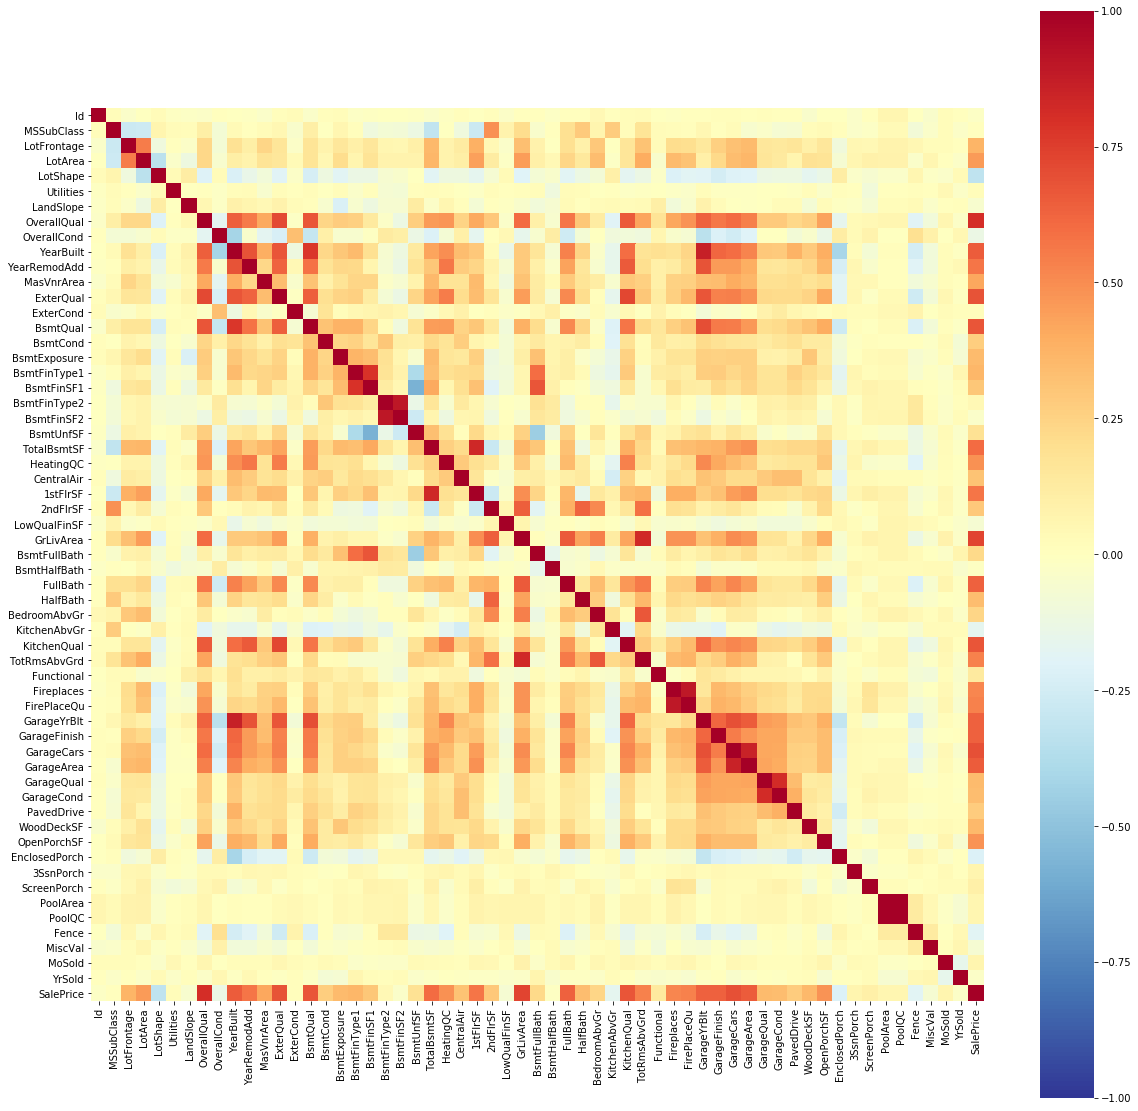

In [105]:
def list_int_features(df) :
    int_features = []
    for x in df.dtypes :
        if x[1] == 'int':
            int_features.append(x[0])
    return int_features

int_features = list_int_features(trainDF)
print(len(int_features))
print(int_features)

vector_col = "corr_features"

def create_corr_matrix(df, col_names) :
    assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    dense_matrix = Correlation.corr(df_vector, vector_col, method="spearman").collect()[0][0] 
    corr_matrix = dense_matrix.toArray().tolist()
    return corr_matrix

corr_matrix = create_corr_matrix(trainDF, int_features)

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, square=True, cmap="RdYlBu_r", vmax=1, vmin=-1, xticklabels=int_features, yticklabels=int_features)

Let's focus on the last row, which represents the correlation between each features and SalePrice. For simplicity, we will select only the most correlated features, that is the ones with a correlation >= 0.5 (positive correlation) or <= -0.5 (negative correlation).

In [106]:
salePrice_corr_row = corr_matrix[len(corr_matrix) - 1]

most_correlated = []
most_correlated_names = []
for i in range (0, len(salePrice_corr_row) - 1) :
    if ((salePrice_corr_row[i] >= 0.5) | (salePrice_corr_row[i] <= -0.5)) :
        most_correlated.append([int_features[i], salePrice_corr_row[i]])
        most_correlated_names.append(int_features[i])

print(len(most_correlated))        
print(most_correlated)

17
[['OverallQual', 0.8098285862017293], ['YearBuilt', 0.6526815462850586], ['YearRemodAdd', 0.5711589780582345], ['ExterQual', 0.6840137963904298], ['BsmtQual', 0.6780262530716663], ['TotalBsmtSF', 0.6027254448924098], ['1stFlrSF', 0.575407835421282], ['GrLivArea', 0.7313095834659141], ['FullBath', 0.6359570562496885], ['KitchenQual', 0.6728485475386914], ['TotRmsAbvGrd', 0.5325859351169926], ['Fireplaces', 0.5192474498367006], ['FirePlaceQu', 0.5376018344871888], ['GarageYrBlt', 0.6340952202911952], ['GarageFinish', 0.6339736230180691], ['GarageCars', 0.6907109670497433], ['GarageArea', 0.649378533886823]]


Let's visualize scatter plots between every features and SalePrice.

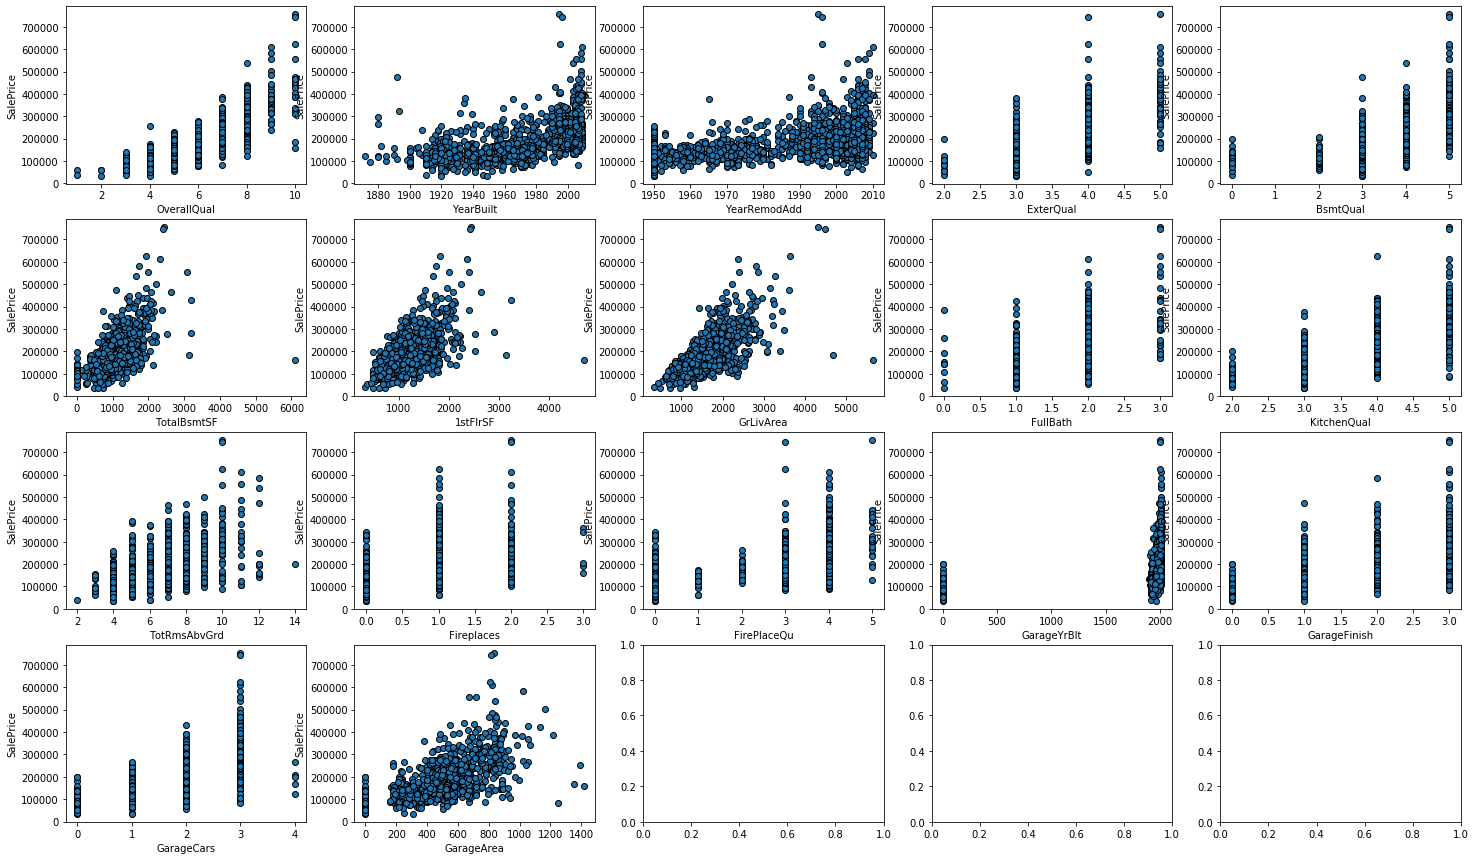

In [107]:
fig, axs = plt.subplots(4, 5, figsize=(25, 15))

for index in range (0, len(most_correlated)) :
    corr = most_correlated_names[index]
    x = [val[corr] for val in trainDF.select(corr).collect()]
    y = [val['SalePrice'] for val in trainDF.select('SalePrice').collect()]
    axs[int(index/5)][index%5].set_xlabel(corr)
    axs[int(index/5)][index%5].set_ylabel('SalePrice')
    axs[int(index/5)][index%5].scatter(x, y, edgecolor='k', linestyle='None')

Strarting from OverallQual, it represents a rating from 1 to 10 of the overall material and finish quality of the house. It has a significant correlation with SalePrice, higher than 0.8. As we can notice, there are two cases in which SalePrice is quite low (about less than 200.000) even if the OverallQual has a rating equal to 10. Are these two data points outliers?

Let's select the two records:

In [108]:
trainDF.select('Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', \
    'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', \
        'FirePlaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice').where((trainDF.OverallQual == 10) & \
        (trainDF.SalePrice <= 200000)).show()

+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
|  Id|OverallQual|YearBuilt|YearRemodAdd|ExterQual|BsmtQual|TotalBsmtSF|1stFlrSF|GrLivArea|FullBath|KitchenQual|TotRmsAbvGrd|Fireplaces|FirePlaceQu|GarageYrBlt|GarageFinish|GarageCars|GarageArea|SalePrice|
+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
| 524|         10|     2007|        2008|        5|       5|       3138|    3138|     4676|       3|          5|          11|         1|          4|       2007|           3|         3|       884|   184750|
|1299|         10|     2008|        2008|        5|       5|       6110|    4692|     5642|       2|          5|          12|         3|          4|       2008|           3|   

Both records are anomalous: the feature 'GrLivArea', highly correlated to SalePrice (0.7), has suspicious high values in both records. If we analyze the scatter plot related to this feature, we can see that these two points are located on bottom right, not following the distribution of the other data points. Same for 1stFlrSF and TotalBsmtSF, as we can clearly see in the respective scatter plots an anomalous data point, that corresponds to the second record. Finally also GarageArea seems to be really high for the second record, moreover it's strange that a garage that large has a capacity equal to only 2 cars.

Finally, our decision is to remove these records.

In [109]:
trainDF = trainDF.where((trainDF.Id != 524) & (trainDF.Id != 1299))

Focusing on the scatter plot of GarageArea, there are two other data points with an high area and a price lower than 200.000. Let's analyze these records:

In [110]:
trainDF.select('Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', \
    'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', \
        'FirePlaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice').where((trainDF.GarageArea > 1000) & \
        (trainDF.SalePrice <= 200000)).show()

+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
|  Id|OverallQual|YearBuilt|YearRemodAdd|ExterQual|BsmtQual|TotalBsmtSF|1stFlrSF|GrLivArea|FullBath|KitchenQual|TotRmsAbvGrd|Fireplaces|FirePlaceQu|GarageYrBlt|GarageFinish|GarageCars|GarageArea|SalePrice|
+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
|1062|          3|     1935|        1950|        2|       3|        894|     894|      894|       1|          3|           6|         0|          0|       1994|           2|         3|      1248|    81000|
|1191|          4|     1961|        1975|        3|       3|       1249|    1622|     1622|       1|          3|           7|         1|          3|       1975|           3|   

Actually, even if GarageArea is high, these records represent old houses since last remodel happened respectively in 1950 and 1975; moreover, highly correlated features as OverallQual have low ratings in both records. So we will not consider these records anomalous.

Another record we want to analyze is the one with TotRmsAbvGrd equal to 14, that is a house with a significantly high number of rooms above grade but with a price equal to 200.000.

In [111]:
trainDF.select('Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', \
    'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', \
        'FirePlaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice').where(trainDF.TotRmsAbvGrd == 14).show()

+---+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
| Id|OverallQual|YearBuilt|YearRemodAdd|ExterQual|BsmtQual|TotalBsmtSF|1stFlrSF|GrLivArea|FullBath|KitchenQual|TotRmsAbvGrd|Fireplaces|FirePlaceQu|GarageYrBlt|GarageFinish|GarageCars|GarageArea|SalePrice|
+---+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
|636|          6|     1914|        1995|        2|       3|       1440|    1440|     3395|       2|          2|          14|         0|          0|          0|           0|         0|         0|   200000|
+---+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+--------

This is a house without a garage, without a fireplace and having a sufficient overall quality, so we can justify the low price.

Now let's focus on records with higher values of SalePrice, recalling that, as we already said, SalePrice distribution has a positive skewness. In particular, in same cases SalePrice is greater than 500.000, that is a price that departs quite a lot from the mean price (about 18.000).

Let's select these records:

In [112]:
trainDF.select('Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', \
    'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', \
        'FirePlaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice').where(trainDF.SalePrice >= 500000) \
            .sort(col('SalePrice').desc()).show()

+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
|  Id|OverallQual|YearBuilt|YearRemodAdd|ExterQual|BsmtQual|TotalBsmtSF|1stFlrSF|GrLivArea|FullBath|KitchenQual|TotRmsAbvGrd|Fireplaces|FirePlaceQu|GarageYrBlt|GarageFinish|GarageCars|GarageArea|SalePrice|
+----+-----------+---------+------------+---------+--------+-----------+--------+---------+--------+-----------+------------+----------+-----------+-----------+------------+----------+----------+---------+
| 692|         10|     1994|        1995|        5|       5|       2444|    2444|     4316|       3|          5|          10|         2|          5|       1994|           3|         3|       832|   755000|
|1183|         10|     1996|        1996|        4|       5|       2396|    2411|     4476|       3|          5|          10|         2|          3|       1996|           3|   

Actually in these records all the features related to quality (OverallQual, ExterQUal, BsmtQual, KitchenQual, FirePlaceQu) have high ratings, and also some numerical features (for example the number of total rooms or bathrooms) take high values. So we don't consider these records anomalous.

3.3 FEATURE SELECTION

In this section, we want to analyze our features and select the most relevant to SalePrice. We already found the most correlated numerical features (both continuous and ordinal) in the previous section, so let's start visualizing them.

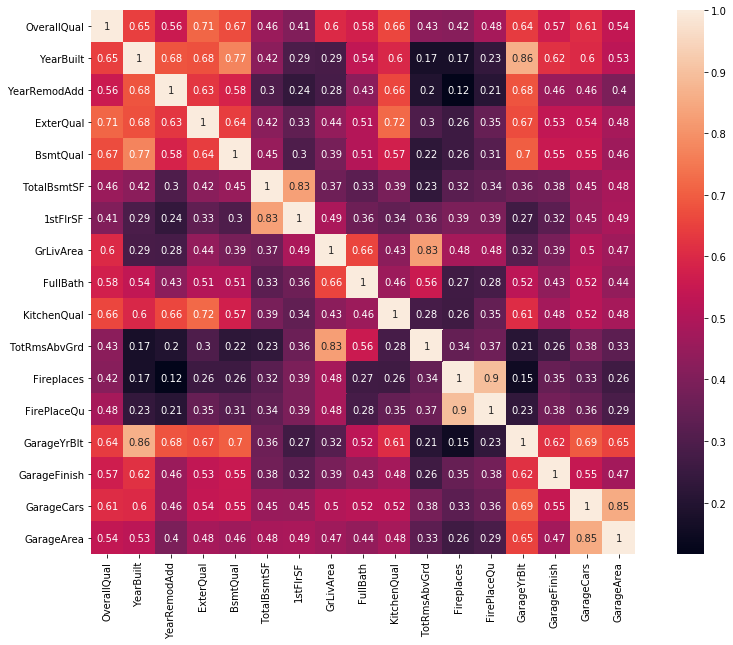

In [113]:
most_correlated_matrix = create_corr_matrix(trainDF, most_correlated_names)

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(most_correlated_matrix, square=True, annot=True, xticklabels=most_correlated_names, yticklabels=most_correlated_names)

We can notice that some of these features are highly correlated between themselves. Generally, we don't want to keep both two correlated features because they are redundant and we want to work in a space that is as simple as possible in term of dimensionality.

So let's select pairs of features highly correlated between themselves, considering a threshold equal to 0.7.

In [114]:
l = len(most_correlated_names)
couples = []

for i in range (0, l) :
    for j in range (0, l) :
        if (i > j) :
            if((most_correlated_matrix[i][j] >= 0.7) & (most_correlated_matrix[i][j] < 1)) :
                couples.append([most_correlated_names[i], most_correlated_names[j], most_correlated_matrix[i][j]])

print(len(couples))
print(couples)

9
[['ExterQual', 'OverallQual', 0.7146344427300502], ['BsmtQual', 'YearBuilt', 0.7735306310397237], ['1stFlrSF', 'TotalBsmtSF', 0.8285891513576804], ['KitchenQual', 'ExterQual', 0.723933389702677], ['TotRmsAbvGrd', 'GrLivArea', 0.8271546979452327], ['FirePlaceQu', 'Fireplaces', 0.8953619734082703], ['GarageYrBlt', 'YearBuilt', 0.8638259960947241], ['GarageYrBlt', 'BsmtQual', 0.7012602230874373], ['GarageArea', 'GarageCars', 0.8535420780033719]]


Starting from OverallQual, we can expect that it has a positive correlation with different features because the overall quality of the house may be understood as a mediation between qualities of different aspects of the house. In this case, we decide to keep all the features.
ExterQual, which represent the exterior material quality, has a correlation of 0.72 with KitchenQual, but logically speaking it doesn't seem that the external quality could be correlated with the kitchen... So we will keep both features.


TotalBsmtSF and 1stFlrSF have a very high correlation, greater than 0.8. They represent respectively the basement area and the first floor area, so the high correlation is probably due to the fact that the basement lies under the first floor so we can always expect a similar dimension, except for houses without a basement (where the area is equal to 0). Realistically, people are more interested in the first floor rather than the basement, so we choose to keep 1stFlrSF and remove TotalBsmtSF.

We can notice a correlation greater than 0.8 also between GrLivArea and TotRmsAbvGrd. This can be easily justified to the fact that larger is the living area, greater is the number of rooms. Since GrLivArea is more correlated to SalePrice, we choose to keep that one and remove TotRmsAbvGrd.


Same thing for GarageCars and GarageArea, with a correlation equal to 0.85. Since GarageCars is more correlated to SalePrice, we choose to keep that one and remove GarageArea.

FirePlaceQu and Fireplaces have a correlation equal to almost 0.9, probably since both features are about fireplaces. We choose to keep FirePlaceQu since it's more correlated to SalePrice.

Finally GarageYrBlt and YearBuilt have high correlation probably because the construction year of the garage is tipically the same as the construction year of the entire house. We choose to keep YearBuilt since it's more correlated to SalePrice.

Another interesting couple we want to analyze is YearBuilt and YearRemodAdd, with a correlation equal to 0.68. This is because some houses haven't been remodeled since the original construction date: in this cases the two features take the same value.

In [115]:
count = trainDF.where(trainDF.YearBuilt == trainDF.YearRemodAdd).count()
tot = trainDF.count()

print(f"Number of records where YearBuilt == YearRemodAdd {count}, that is {(count/tot)*100} %")

Number of records where YearBuilt == YearRemodAdd 763, that is 52.33196159122085 %


Actually these two features take the same value for more than 50% of train data: this fact explains the high correlation, but of course it isn't an optimal situation. We choose to keep YearBuilt since it's more correlated to SalePrice. 

In summary, we kept the following numerical features:

In [116]:
int_features = most_correlated_names.copy()
int_features.remove('TotalBsmtSF')
int_features.remove('TotRmsAbvGrd')
int_features.remove('GarageArea')
int_features.remove('Fireplaces')
int_features.remove('GarageYrBlt')
int_features.remove('YearRemodAdd')

print(int_features)

['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'FirePlaceQu', 'GarageFinish', 'GarageCars']


Now, we have to analyze nominal categorical features. Let's select them.

In [117]:
def list_str_categories(df) :
    category_labels = []
    for x in df.dtypes :
        if x[1] == 'string':
            category_labels.append(x[0])
    return category_labels

categories_list = list_str_categories(trainDF)
size = len(categories_list)
print(f"Found {size} columns of type string \n")
print(categories_list)

Found 22 columns of type string 

['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


To avoid redundancy, first of all we have to verify if there are features with the same category in the majority of train data. We consider a threshold of 95%.

In [118]:
tot = trainDF.count()

list_frequent = []
for c in categories_list :
    temp = trainDF.groupBy(c).count() \
        .withColumn('percentage', (col('count') / tot) * 100 ) \
        .sort(col('percentage').desc())
    #temp.show()
    l = temp.collect()
    if(l[0][2] >= 95) :
        temp.show()
        list_frequent.append(c)

+------+-----+-----------------+
|Street|count|       percentage|
+------+-----+-----------------+
|  Pave| 1452|99.58847736625515|
|  Grvl|    6|0.411522633744856|
+------+-----+-----------------+

+----------+-----+-------------------+
|Condition2|count|         percentage|
+----------+-----+-------------------+
|      Norm| 1444|    99.039780521262|
|     Feedr|    6|  0.411522633744856|
|    Artery|    2| 0.1371742112482853|
|      RRNn|    2| 0.1371742112482853|
|      PosN|    1|0.06858710562414265|
|      RRAe|    1|0.06858710562414265|
|      RRAn|    1|0.06858710562414265|
|      PosA|    1|0.06858710562414265|
+----------+-----+-------------------+

+--------+-----+-------------------+
|RoofMatl|count|         percentage|
+--------+-----+-------------------+
| CompShg| 1433|  98.28532235939643|
| Tar&Grv|   11| 0.7544581618655692|
| WdShngl|    6|  0.411522633744856|
| WdShake|    5| 0.3429355281207133|
| Membran|    1|0.06858710562414265|
|   Metal|    1|0.06858710562414265|

So features with a percentage greater than 95% for one category are the following:

In [119]:
print(len(list_frequent))
print(list_frequent)

5
['Street', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature']


Let's visualize scatter plots for these features:

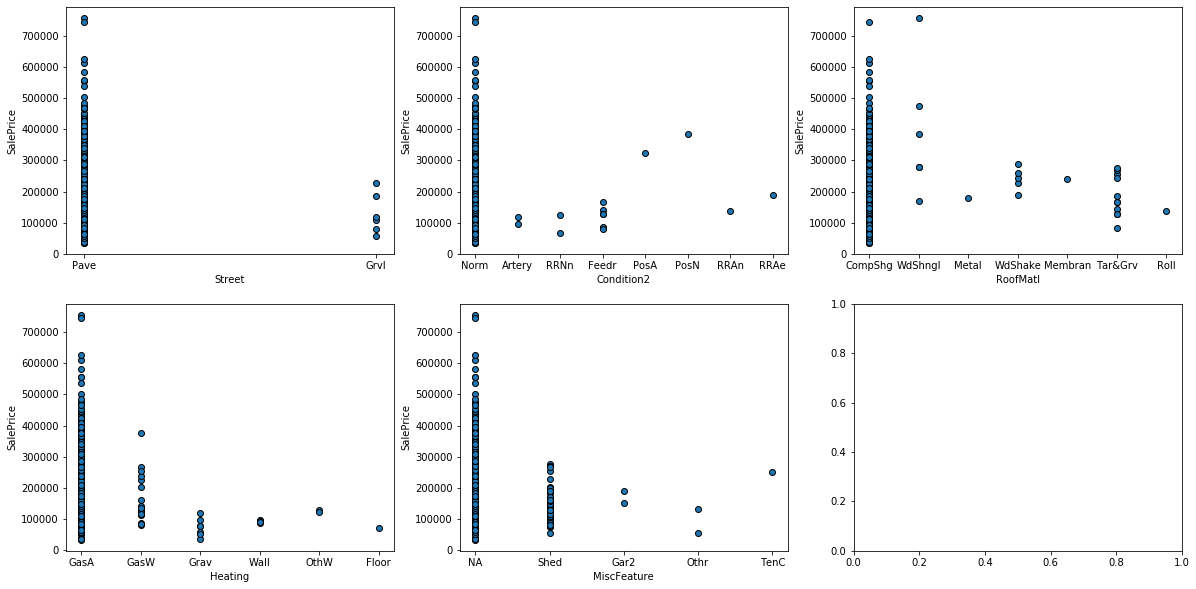

In [120]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for index in range (0, len(list_frequent)) :
    category = list_frequent[index]
    x = [val[category] for val in trainDF.select(category).collect()]
    y = [val['SalePrice'] for val in trainDF.select('SalePrice').collect()]
    axs[int(index/3)][index%3].set_xlabel(category)
    axs[int(index/3)][index%3].set_ylabel('SalePrice')
    axs[int(index/3)][index%3].scatter(x, y, edgecolor='k', linestyle='None')

We can notice that actually for all of these features we have a single prevailing category and only a few data points scattered among different categories. We don't want to remove all of these features, but instead of considering a lot of categories with a few data points, we can group them in a single category called "Other".

In [121]:
trainDF = trainDF.withColumn('Condition2', when(( \
    (col('Condition2') == 'Artery') | \
    (col('Condition2') == 'RRNn') | \
    (col('Condition2') == 'Feedr') | \
    (col('Condition2') == 'PosA') | \
    (col('Condition2') == 'PosN') | \
    (col('Condition2') == 'RRAn') | \
    (col('Condition2') == 'RRAe')), 'Other').otherwise(trainDF['Condition2']))

testDF = testDF.withColumn('Condition2', when(( \
    (col('Condition2') == 'Artery') | \
    (col('Condition2') == 'RRNn') | \
    (col('Condition2') == 'Feedr') | \
    (col('Condition2') == 'PosA') | \
    (col('Condition2') == 'PosN') | \
    (col('Condition2') == 'RRAn') | \
    (col('Condition2') == 'RRAe')), 'Other').otherwise(testDF['Condition2']))

trainDF = trainDF.withColumn('RoofMatl', when(( \
    (col('RoofMatl') == 'WdShngl') | \
    (col('RoofMatl') == 'Metal') | \
    (col('RoofMatl') == 'WdShake') | \
    (col('RoofMatl') == 'Membran') | \
    (col('RoofMatl') == 'Tar&Grv') | \
    (col('RoofMatl') == 'Roll')), 'Other').otherwise(trainDF['RoofMatl']))

testDF = testDF.withColumn('RoofMatl', when(( \
    (col('RoofMatl') == 'WdShngl') | \
    (col('RoofMatl') == 'Metal') | \
    (col('RoofMatl') == 'WdShake') | \
    (col('RoofMatl') == 'Membran') | \
    (col('RoofMatl') == 'Tar&Grv') | \
    (col('RoofMatl') == 'Roll')), 'Other').otherwise(testDF['RoofMatl']))

trainDF = trainDF.withColumn('Heating', when(( \
    (col('Heating') == 'GasW') | \
    (col('Heating') == 'Grav') | \
    (col('Heating') == 'Wall') | \
    (col('Heating') == 'OthW') | \
    (col('Heating') == 'Floor')), 'Other').otherwise(trainDF['Heating']))

testDF = testDF.withColumn('Heating', when(( \
    (col('Heating') == 'GasW') | \
    (col('Heating') == 'Grav') | \
    (col('Heating') == 'Wall') | \
    (col('Heating') == 'OthW') | \
    (col('Heating') == 'Floor')), 'Other').otherwise(testDF['Heating']))

trainDF = trainDF.withColumn('MiscFeature', when(( \
    (col('MiscFeature') == 'Shed') | \
    (col('MiscFeature') == 'Gar2') | \
    (col('MiscFeature') == 'Othr') | \
    (col('MiscFeature') == 'TenC')), 'Other').otherwise(trainDF['MiscFeature']))

testDF = testDF.withColumn('MiscFeature', when(( \
    (col('MiscFeature') == 'Shed') | \
    (col('MiscFeature') == 'Gar2') | \
    (col('MiscFeature') == 'Othr') | \
    (col('MiscFeature') == 'TenC')), 'Other').otherwise(testDF['MiscFeature']))


Now we want to understand how much these features are related to SalePrice, but we need numerical values. We can use the StringIndexer tool from PySpark, which maps a string column of labels to an ML column of label indices, based on the selected ordered type. In our case, we chose the frequency ordering, so the most frequent label becomes 0 as index and so on. To calculate frequency in an accurate way, we will consider the union of train and test set.

In [122]:
unionDF = trainDF[categories_list].unionByName(testDF[categories_list])

indexers = [StringIndexer(inputCol = column, outputCol = column+"_index").fit(unionDF) for column in categories_list]

for indexer in indexers:
    trainDF = indexer.transform(trainDF)
    testDF = indexer.transform(testDF)

Let's try to use a RandomForest to have a measure of the importance of each feature basing on how much they vary with respect to SalePrice: in fact, every feature will be grouped by category and for each category we have a measure of the variance of SalePrice. So the most important features are the ones that allows us to obtain low variance partitions based on SalePrice.

We will use the attribute "featureImportances" in PySpark.

In [123]:
features = [f'{category}_index' for category in categories_list]

assembler = VectorAssembler(inputCols = features, outputCol = 'Features')
output = assembler.transform(trainDF)

rf_sel = RandomForestRegressor(featuresCol='Features', labelCol= 'SalePrice', impurity="variance")

final_df = output.select('Features', 'SalePrice')

model = rf_sel.fit(final_df)

importance_list = model.featureImportances.toArray().tolist()

importance = []
for i in range (0, len(importance_list) -1) :
    couple = [categories_list[i], importance_list[i]]
    importance.append(couple)

importanceDF = spark.createDataFrame(data = importance, schema = ["Feature", "Importance"])
importanceDF = importanceDF.withColumn('Importance', round(col('Importance'), 5))
importanceDF.show()

+------------+----------+
|     Feature|Importance|
+------------+----------+
|    MSZoning|   0.01623|
|      Street|       0.0|
|       Alley|   0.00279|
| LandContour|   0.00841|
|   LotConfig|   0.00771|
|Neighborhood|   0.44535|
|  Condition1|    0.0018|
|  Condition2|    3.2E-4|
|    BldgType|   0.02336|
|  HouseStyle|   0.02124|
|   RoofStyle|   0.03539|
|    RoofMatl|   0.02066|
| Exterior1st|   0.04381|
| Exterior2nd|   0.03893|
|  MasVnrType|   0.06006|
|  Foundation|   0.15131|
|     Heating|    5.5E-4|
|  Electrical|   0.00241|
|  GarageType|   0.09639|
| MiscFeature|    1.1E-4|
+------------+----------+
only showing top 20 rows



We can notice that most features have a very low score, in some cases it even becomes 0. 
Let's select features with a score of at least 0.1.

In [124]:
importanceDF.where(col('Importance') >= 0.1).show()

+------------+----------+
|     Feature|Importance|
+------------+----------+
|Neighborhood|   0.44535|
|  Foundation|   0.15131|
+------------+----------+



Basing on this condition, Neighborhood and Foundation are the most relevant features.

Finally, all the features we selected in this section are the following:

In [125]:
categories_list = ['Neighborhood', 'Foundation']

features = []
features.extend(int_features)
features.extend(categories_list)

print(len(features))
print(features)

13
['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'FirePlaceQu', 'GarageFinish', 'GarageCars', 'Neighborhood', 'Foundation']


4 BUILDING OF THE TRAINING PIPELINE

Since our goal is to predict a price, we want to build a regression model. In particular, we will try three different models:

1. Linear Regression
2. Random Forest Regression
3. Gradient-boosting Regression

4.1 PRELIMINARY STAGE: STRING INDEXERS AND ONE-HOT ENCODERS 

We already converted categorical data to indexers through the StringIndexer tool, but we have another tool in PySpark, OneHotEncoder, which maps a column of category indices to a column of binary vectors, with a single one-value per row that indicates the input category index. Of course OHE are less efficient in term of memory, since we have for each feature a vector with a dimension depending on the number of the categories of that feature instead of a single index. Working with vectors ensures better performance for models like linear regression, but vectors are not needed for tree-based models as Random Forest or Gradient-boosting.

So we want to consider features mapped as indexes or as vectors depending on the model.

First of all, let's convert nominal categorical features to one-hot vectors. 

In [126]:
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_vector").fit(trainDF) for column in categories_list]

for encoder in encoders:
    trainDF = encoder.transform(trainDF)
    testDF = encoder.transform(testDF)

So we will choose one of these two groups of features for each model:

In [127]:
features1 = int_features.copy()
features1.extend([f'{column}_index' for column in categories_list])
print(len(features1))
print(features1)

features2 = int_features.copy()
features2.extend([f'{column}_vector' for column in categories_list])
print(len(features2))
print(features2)

13
['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'FirePlaceQu', 'GarageFinish', 'GarageCars', 'Neighborhood_index', 'Foundation_index']
13
['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'FirePlaceQu', 'GarageFinish', 'GarageCars', 'Neighborhood_vector', 'Foundation_vector']


4.2 LOSS FUNCTION

In order to evaluate and confronting our models, we want to choose a loss function for regression that is common to all three.

A tipical loss function is Mean Squared Error (MSE), but since in our case we're dealing with prices, so very large values, MSE would result in large values too, not too easy to understand. So we will use a Rooted Mean Squared Error (RMSE), because the square root helps us to contain large values. 

In [128]:
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol='prediction', metricName='rmse')

To better visualize and confronting losses for our three models, we will normalize RMSE dividing it by the range [max(SalePrice) - min(SalePrice)].

4.3 LINEAR REGRESSION

Let's build our training pipeline, starting from the linear regression model.

The first stage of our pipeline is given by VectorAssembler, a feature transformer that merges multiple columns into a vector column. In this case, as we already said, we will consider the group of features with one-hot vectors in place of nominal categorical features.

Then, we add our model, LinearRegression, to the pipeline.

In [129]:
stages = []

lr_assembler = VectorAssembler().setInputCols(features2).setOutputCol('Features').setHandleInvalid("keep")
stages.append(lr_assembler)

lr = LinearRegression(featuresCol='Features', labelCol= 'SalePrice')
stages.append(lr)

lr_pipeline = Pipeline().setStages(stages)

Let's use a K-fold cross validation with k=10: this method splits dataset in 10 non-overlapping partitions, 9 of them for training and the one for validation.

In [130]:
#regParam: parametri di regolarizzazione 
#elasticNetParam: valore da 0 a 1 (alfaa = 0 -> L2 penalty; alfa = 1 -> L1 penalty)
#maxIter: massimo numero di iterazioni
lr_paramgrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
             .addGrid(lr.maxIter, [1, 5, 10, 20, 50]) \
             .build())

lr_cv = CrossValidator().setEstimator(lr_pipeline) \
                     .setEvaluator(evaluator) \
                     .setEstimatorParamMaps(lr_paramgrid) \
                     .setNumFolds(10)

Now we can train the model on train set and make predictions on test set.

In [131]:
lr_cvmodel = lr_pipeline.fit(trainDF)
lr_predictions = lr_cvmodel.transform(testDF)
lr_predictions.select('Id', 'prediction').show()

+----+------------------+
|  Id|        prediction|
+----+------------------+
|1461|102948.66343246959|
|1462|163448.95384319592|
|1463|162314.40054278192|
|1464|174674.85858356685|
|1465|248070.03439663711|
|1466| 168891.5745908249|
|1467|154775.01417550864|
|1468|161025.04314956279|
|1469|193230.41656262008|
|1470|105988.11452343222|
|1471|204867.37286738283|
|1472| 96040.32904105284|
|1473| 91969.35155959066|
|1474| 153414.7816894214|
|1475|126230.81329449709|
|1476| 370356.7816994282|
|1477|274510.12874428835|
|1478|328107.62036261486|
|1479|324492.80332077725|
|1480|422919.89219526993|
+----+------------------+
only showing top 20 rows



In order to evaluate performance, let's predict prices on train data and calculate the loss giving the true values of SalePrice.

In [132]:
lr_performance = lr_cvmodel.transform(trainDF)
lr_performance.select('SalePrice', 'prediction').show()
lr_rmse = evaluator.evaluate(lr_performance)

max_SalePrice = trainDF.agg({"SalePrice": "max"}).collect()[0][0]
min_SalePrice = trainDF.agg({"SalePrice": "min"}).collect()[0][0]
range_SalePrice = max_SalePrice - min_SalePrice

print(f"Normalized rmse: {lr_rmse/range_SalePrice}")

+---------+------------------+
|SalePrice|        prediction|
+---------+------------------+
|   208500| 206370.5708886569|
|   181500|190067.96757763322|
|   223500|214419.50684262475|
|   140000|208365.19842118898|
|   250000| 307100.4603585206|
|   143000|128054.69390210533|
|   307000|263279.96115342237|
|   200000|207557.50914805336|
|   129900| 160028.0631426433|
|   118000|125695.00647809554|
|   129500|118517.92205542058|
|   345000| 347707.8389776334|
|   144000|107071.09236511553|
|   279500|226011.89671636303|
|   157000|149114.34180405294|
|   132000| 129223.0582486029|
|   149000| 140807.8267782894|
|    90000| 112718.5495122245|
|   159000| 136901.9037448006|
|   139000|140433.43660792743|
+---------+------------------+
only showing top 20 rows

Normalized rmse: 0.04250801658548227


4.4 RANDOM FOREST

Now, we want to test a Random Forest model. In this case we prefer the group of features with indexes.

Let's build the pipeline.

In [133]:
stages = []

rf_assembler = VectorAssembler().setInputCols(features1).setOutputCol('Features').setHandleInvalid("keep")
stages.append(rf_assembler)

rf = RandomForestRegressor(featuresCol='Features', labelCol= 'SalePrice')
stages.append(rf)

rf_pipeline = Pipeline().setStages(stages)

In this case as a measure of "impurity" we will use the variance as it's typical for regression tasks.

In [134]:
#maxBins: bins per discretizzare features numeriche
#maxDepth: prodondità massima degli alberi
#impurity: misura di impurità per scegliere tra gli splits
rf_paramgrid = ParamGridBuilder().addGrid(rf.maxBins, [25, 28, 31, 34, 36])\
                              .addGrid(rf.maxDepth, [4, 6, 8, 10, 12])\
                              .addGrid(rf.impurity, ["variance"])\
                              .build()

rf_cv = CrossValidator().setEstimator(rf_pipeline) \
                     .setEvaluator(evaluator) \
                     .setEstimatorParamMaps(rf_paramgrid) \
                     .setNumFolds(10)

In [135]:
rf_cvmodel = rf_pipeline.fit(trainDF)
rf_predictions = rf_cvmodel.transform(testDF)
rf_predictions.select('Id', 'prediction').show()

+----+------------------+
|  Id|        prediction|
+----+------------------+
|1461| 122681.8621169572|
|1462|147106.43189826803|
|1463| 181470.9114044012|
|1464|181898.50634715028|
|1465|225317.11485626944|
|1466|180562.48829356057|
|1467|172366.03869077686|
|1468|179692.58587261193|
|1469|183516.11438584546|
|1470|125495.73717520133|
|1471| 184181.2992708839|
|1472|107816.54824576204|
|1473|112852.66795765221|
|1474|154620.94841315885|
|1475|141072.49625323561|
|1476|404626.12777138647|
|1477|269686.53737380897|
|1478|329556.09027780284|
|1479| 314463.8897462288|
|1480| 434849.8704881702|
+----+------------------+
only showing top 20 rows



Finally let's evaluate the model.

In [136]:
rf_performance = rf_cvmodel.transform(trainDF)
rf_performance.select('SalePrice', 'prediction').show()
rf_rmse = evaluator.evaluate(rf_performance)

print(f"Normalized rmse: {rf_rmse/range_SalePrice}")

+---------+------------------+
|SalePrice|        prediction|
+---------+------------------+
|   208500|200222.16863540767|
|   181500|174149.32992717595|
|   223500|212088.18442080246|
|   140000|188759.15914998198|
|   250000|299060.51157434756|
|   143000|141548.90640307294|
|   307000| 275156.7891941342|
|   200000|204433.49467842822|
|   129900|151940.80355639238|
|   118000|124211.42607851462|
|   129500|128516.19894828205|
|   345000| 396018.0974140716|
|   144000|125453.55975711372|
|   279500|217968.64598481025|
|   157000|152081.96973836256|
|   132000|131799.54572705945|
|   149000|145099.80551685876|
|    90000|132791.33075776167|
|   159000| 140908.3597845756|
|   139000|139827.89536108117|
+---------+------------------+
only showing top 20 rows

Normalized rmse: 0.03548085519008177


4.5 GRADIENT BOOSTED

The last model is Gradient Boosting. Since it's based on decision trees, we will consider the group of features with indexes.

In [137]:
stages = []

gb_assembler = VectorAssembler().setInputCols(features1).setOutputCol('Features').setHandleInvalid("keep")
stages.append(gb_assembler)

gb = GBTRegressor(featuresCol='Features', labelCol= 'SalePrice')
stages.append(gb)

gb_pipeline = Pipeline().setStages(stages)

In [138]:
gb_paramgrid = ParamGridBuilder().addGrid(gb.maxBins, [25, 28, 31, 34, 36])\
                              .addGrid(gb.maxDepth, [4, 6, 8, 10, 12])\
                              .addGrid(gb.impurity, ["variance"])\
                              .build()

gb_cv = CrossValidator().setEstimator(gb_pipeline) \
                     .setEvaluator(evaluator) \
                     .setEstimatorParamMaps(gb_paramgrid) \
                     .setNumFolds(10)

In [139]:
gb_cvmodel = gb_pipeline.fit(trainDF)
gb_predictions = gb_cvmodel.transform(testDF)
gb_predictions.select('Id', 'prediction').show()

+----+------------------+
|  Id|        prediction|
+----+------------------+
|1461|122127.75533057348|
|1462|148197.23528345348|
|1463|177332.65363074729|
|1464|177013.99028419275|
|1465|199079.88518044617|
|1466|177332.65363074729|
|1467|182389.53677731397|
|1468|177971.09649978255|
|1469| 180510.0271439209|
|1470| 119239.1594900343|
|1471|160145.39586914028|
|1472| 94057.10830003355|
|1473|104753.03517211728|
|1474| 155102.6398633856|
|1475| 133643.3753137079|
|1476| 404505.8592512251|
|1477|276060.36221490195|
|1478| 363806.6804208379|
|1479| 303967.9284526737|
|1480| 484046.0628844576|
+----+------------------+
only showing top 20 rows



In [140]:
gb_performance = gb_cvmodel.transform(trainDF)
gb_performance.select('SalePrice', 'prediction').show()
gb_rmse = evaluator.evaluate(gb_performance)

print(f"Normalized rmse: {gb_rmse/range_SalePrice}")

+---------+------------------+
|SalePrice|        prediction|
+---------+------------------+
|   208500|183348.42233977243|
|   181500|182198.18805628503|
|   223500|225969.23033320982|
|   140000|172774.74414235874|
|   250000|297079.15831083804|
|   143000|143315.71854616667|
|   307000| 298417.4295770593|
|   200000| 209747.8988485942|
|   129900|152984.09332164537|
|   118000|125712.92812602539|
|   129500|  124731.658186645|
|   345000| 348313.7894751316|
|   144000|122516.03450458893|
|   279500|210549.11592632433|
|   157000|150493.75055188648|
|   132000|115448.45746394509|
|   149000|132758.58205129087|
|    90000| 96777.07728274539|
|   159000|145060.80091101446|
|   139000|138725.49751002982|
+---------+------------------+
only showing top 20 rows

Normalized rmse: 0.025909263321697306


5 MODELS COMPARISON AND CONCLUSIONS

Let's compare losses for our three models.

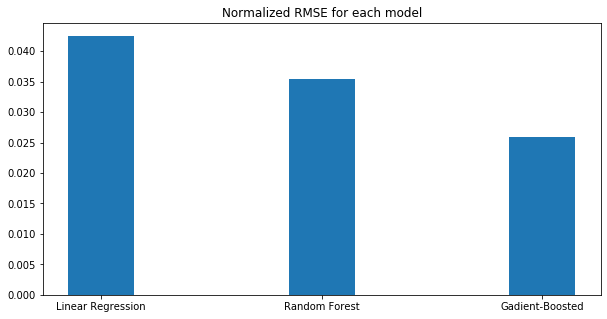

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Normalized RMSE for each model')
names = ['Linear Regression', 'Random Forest', 'Gadient-Boosted']
values = [lr_rmse/range_SalePrice, rf_rmse/range_SalePrice, gb_rmse/range_SalePrice]

rmse_comparison = plt.bar(names, values, width=0.3)

We can notice that Linear Regression is the worst model. Random Forest performs better, but Gradient Boosting is the absolute best, with a loss of about 0.025.

Finally, we can save the csv file and submit it on Kaggle.

In [142]:
gb_predictions.withColumnRenamed('prediction','SalePrice')\
            .select('Id','SalePrice')\
            .coalesce(1)\
            .write.csv('output',mode='overwrite',header=True)

Our rating is: 0.17038.